In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
# # Build neural network architecture
# class simple_network(nn.Module):

#     def __init__(self, input_size = 2):
#         super().__init__()

#         # network
#         self.network = nn.Sequential(
#             nn.Linear(input_size, 32),
#             nn.Tanh(),
#             nn.Linear(32, 32),
#             nn.Tanh(),
#             nn.Linear(32, 1),
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.network(x)
    
class simple_network(nn.Module):

    def __init__(self, input_size = 2):
        super().__init__()
        self.fc1 =  nn.Linear(input_size, 32)
        self.fc2 =  nn.Tanh()
        self.fc3 =  nn.Linear(32, 32)
        self.fc4 =  nn.Tanh()
        self.fc5 =  nn.Linear(32, 1)


    def forward(self,x: torch.Tensor):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x) 
        x = torch.Tensor(x)
        return x
    
    
    


In [4]:
class ensemble_network(nn.Module):

    def __init__(self, N, model_params, model_name = None):
        super().__init__()

        # check if model is already implemented
        implemented_models = {'heston', 'BS'}
        if model_name not in implemented_models:
            if model_name is None: print('Please specify model.')
            else: print(f'Model {model_name} is not implemented yet.')
            return

        # params
        self.N = N
        self.model_name = model_name
        self.model_params = model_params

        # the model will be initialized with N neural networks of type simple_network
        model = []
        parameter_list = nn.ParameterList()
        for i in range(N):
            # Heston model
            if model_name == 'heston':
                self.input_size = 3
                temporary_model = simple_network(input_size = self.input_size)
            # BS model
            if model_name == 'BS':
                self.input_size = 2
                temporary_model = simple_network(input_size = self.input_size)
            # append to model list
            model.append(temporary_model)
            parameter_list.extend(temporary_model.parameters())
        # set model
        self.model = model

        # create list of parameters of the model
        self.parameters = parameter_list


    def forward(self, X_train: torch.Tensor) -> torch.Tensor:

        if self.model_name == 'heston':
            # assert that length of training data matches (noise data for stock and volatility)
            assert(2 * self.N == X_train.shape[0])

            # parameters ()
            T = self.model_params['T']
            h = T / self.N
            v0 = self.model_params['v0']
            S0 = self.model_params['S0']
            X0 = self.model_params['X0']
            mu = self.model_params['mu']
            r = self.model_params['r']
            rho = self.model_params['rho']
            kappa = self.model_params['kappa']
            theta = self.model_params['theta']
            xi = self.model_params['xi']

            # initialize volatility, (log) price and (log) wealth
            v = v0 * torch.ones_like(X_train[0], dtype = torch.float32)
            S = S0 * torch.ones_like(X_train[0], dtype = torch.float32)
            X = X0 * torch.ones_like(X_train[0], dtype = torch.float32)
            logS = torch.log(S)
            logX = torch.log(X)

            # initialize integrated variance
            integrated_variance = torch.zeros_like(X_train[0], dtype = torch.float32)

            # iterate
            for i in range(N):

                ### integrated variance
                if i > 0:
                    integrated_variance = integrated_variance + 1 / S ** 2 * (S - S_for_integrated_variance) ** 2

                ### wealth update

                # create tensor, which will be fed into the network; in this case current stock, wealth and volatility data
                input_tensor = torch.transpose(torch.vstack((S, X, integrated_variance)), 0, 1)
                # alpha corresponds to the neural net evaluated at the input data
                alpha = self.model[i](input_tensor).squeeze()
                # update (log) wealth according to Euler-Maruyama scheme
                logX = logX + (alpha * mu + (1 - alpha) * r - alpha ** 2 * v / 2) * h + alpha * torch.sqrt(v * h) * X_train[i,] 
                X = torch.exp(logX)

                ### stock update

                # update (log) stock price according to Euler-Maruyama scheme
                S_for_integrated_variance = S
                logS = logS + (mu - v / 2) * h + torch.sqrt(v * h) * X_train[i,]
                S = torch.exp(logS)

                ### volatility update

                # first build a correlated Brownian motion, then update the volatility
                Z = (rho * X_train[i,] + np.sqrt(1 - rho ** 2) * X_train[N + i,])
                v = v + kappa * (theta - v) * h + xi * torch.sqrt(v * h) * Z

            # return output
            return X

        elif self.model_name == 'BS':
            # assert that length of training data matches (noise data for stock)
            assert(self.N == X_train.shape[0])

            # parameters
            T = self.model_params['T']
            h = T / self.N
            S0 = self.model_params['S0']
            X0 = self.model_params['X0']
            mu = self.model_params['mu']
            r = self.model_params['r']
            sigma = self.model_params['sigma']

            # initialize volatility, (log) price and (log) wealth
            S = S0 * torch.ones_like(X_train[0], dtype = torch.float32)
            X = X0 * torch.ones_like(X_train[0], dtype = torch.float32)
            logS = torch.log(S)
            logX = torch.log(X)

            # iterate
            for i in range(self.N): #changed to self
                ### wealth update
                input_tensor = torch.transpose(torch.vstack((S, X)), 0, 1)
                alpha = self.model[i](input_tensor).squeeze()
                logX = logX + (alpha * mu + (1 - alpha) * r - alpha ** 2 * sigma ** 2 / 2) * h + alpha * sigma * np.sqrt(h) * X_train[i,]
                X = torch.exp(logX)

                ### stock update
                logS = logS + (mu - sigma ** 2 / 2) * h + sigma * np.sqrt(h) * X_train[i,]
                S = torch.exp(logS)

            # return output
            return X

        else:
            print(f"Model {self.model_name} is not yet implemented.")
            return

        # additional method which outputs the strategy alpha according to the simple neural networks (used for analysis later)
    def strategy(self, t, *args):
        # assert right input for neural net
        assert(len(args) == self.input_size)

        # create input tensor for neural net
        input_tensor = torch.tensor(args, dtype = torch.float)

        # return evaluated net
        return self.model[t](input_tensor)

In [5]:
# financial parameters for the Heston model
model_params_heston = {
    'T' : 1.0,
    'r' : 0.0,
    'X0' : 1.0,
    'S0' : 1.0,
    'mu' : 0.1,
    'v0': 0.04,
    'kappa' : 2.0,
    'theta' : 0.05,
    'xi' : 0.03,
    'rho' : -0.14
}

# financial parameters for the BS model
model_params_BS = {
    'T' : 1.0,
    'r' : 0.0,
    'X0' : 1.0,
    'S0' : 1.0,
    'mu' : 0.1,
    'sigma': 0.2
}

In [6]:
def build_data_heston(N = 30, K = 10 ** 5):
    # generate i.i.d. normal variables
    data = np.random.normal(loc = 0, scale = 1, size = (2 * N, K)) #2*N to be able to generate corralated standard normals in the forward pass of heston
    # format as tensor
    data = torch.tensor(data, dtype = torch.float)
    # info that data was built
    print(f'Data built. Shape of data : {data.shape}')
    return data


def build_data_BS(N = 30, K = 10 ** 5):
    # generate i.i.d. normal variables
    data = np.random.normal(loc = 0, scale = 1, size = (N, K))
    # format as tensor
    data = torch.tensor(data, dtype = torch.float)
    # info that data was built
    print(f'Data built. Shape of data : {data.shape}')
    return data

In [7]:
# time discretization
N = 30

# number of paths for training and testing
K = 10 ** 4
L = 10 ** 4

# build training data for Heston and BS model
np.random.seed(12345)
X_train_heston = build_data_heston(N, K)
X_test_heston = build_data_heston(N, L)
X_train_BS = build_data_BS(N, K)
X_test_BS = build_data_BS(N, L)

# define the two models
model_heston = ensemble_network(N, model_params_heston, 'heston')
model_BS = ensemble_network(N, model_params_BS, 'BS')

print(X_test_heston[0].shape)

Data built. Shape of data : torch.Size([60, 10000])
Data built. Shape of data : torch.Size([60, 10000])
Data built. Shape of data : torch.Size([30, 10000])
Data built. Shape of data : torch.Size([30, 10000])
torch.Size([10000])


In [8]:
# Choose custom loss function
def loss_fn(y_pred):
    loss = -torch.mean(torch.log(y_pred)) # expected utility (expected bc of the mean): negative expected log utility (minimization problem)
    return loss

# Choose optimizer
optimizer_heston = torch.optim.Adam(params = model_heston.parameters(), lr = 0.001)
optimizer_BS = torch.optim.Adam(params = model_BS.parameters(), lr = 0.001)

In [9]:
def train_model(model, optimizer, loss_fn, X_train, X_test = torch.randn((N, 1)), epochs = 100):
    # Track epochs and (training and testing) losses
    epoch_count = []
    train_loss_values = []
    test_loss_values = []

    # training loop
    for epoch in range(epochs):

        # activate training mode
        model.train()

        # 1. Forward pass
        y_pred = model.forward(X_train)

        # 2. Calculate loss
        loss = loss_fn(y_pred)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backward pass
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # deactivate training mode
        model.eval()

        # console update
        if epoch % 10 == 0 and epoch > 0:
            # append epochs, training and test loss
            epoch_count.append(epoch)
            train_loss_values.append(loss_fn(model.forward(X_train)))
            test_loss_values.append(loss_fn(model.forward(X_test)))

            #print console update
            print(f"Epoch : {epoch}/{epochs} | Training Loss : {train_loss_values[-1]} | Test Loss : {test_loss_values[-1]}")

    # plot training and test loss
    plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label = "Train loss")
    plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label = "Test loss")
    plt.title("Training and test loss curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

Epoch : 10/100 | Training Loss : -0.04633016884326935 | Test Loss : -0.04799360781908035
Epoch : 20/100 | Training Loss : -0.08248395472764969 | Test Loss : -0.08548849821090698
Epoch : 30/100 | Training Loss : -0.10630019754171371 | Test Loss : -0.11038196831941605
Epoch : 40/100 | Training Loss : -0.11926999688148499 | Test Loss : -0.12386228144168854
Epoch : 50/100 | Training Loss : -0.12478043138980865 | Test Loss : -0.1291738599538803
Epoch : 60/100 | Training Loss : -0.12657000124454498 | Test Loss : -0.13027942180633545
Epoch : 70/100 | Training Loss : -0.1270652860403061 | Test Loss : -0.13002775609493256
Epoch : 80/100 | Training Loss : -0.12725475430488586 | Test Loss : -0.1296961009502411
Epoch : 90/100 | Training Loss : -0.12737734615802765 | Test Loss : -0.12956653535366058


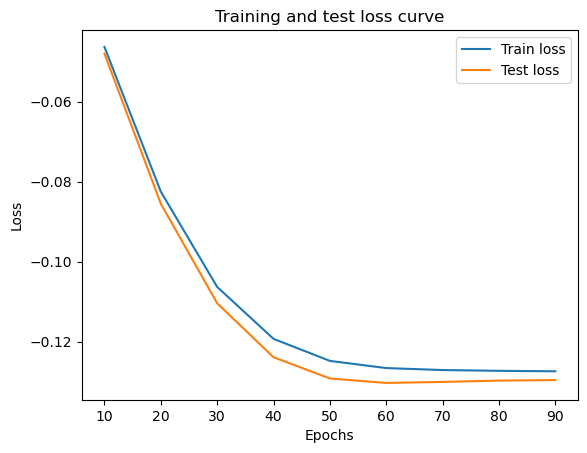

In [10]:
train_model(model_BS, optimizer_BS, loss_fn, X_train_BS, X_test_BS, epochs = 100)

In [11]:
def merton_strategy(model_params):
    mu = model_params['mu']
    r = model_params['r']
    sigma = model_params['sigma']
    return (mu - r) / sigma ** 2

def optimal_expected_log_utility(model_params):
    mu = model_params['mu']
    r = model_params['r']
    sigma = model_params['sigma']
    T = model_params['T']
    X0 = model_params['X0']
    return np.log(X0) + T * (r + (mu - r) ** 2 / sigma ** 2 / 2)

In [12]:
# theorectically optimal strategy and utility
print(f"Merton strategy : {merton_strategy(model_params_BS)}")
print(f"Optimal negative expected log utility :  {-optimal_expected_log_utility(model_params_BS)}")

# achieved utility by network
print(f"Negative expected log utility by ensemble network : {loss_fn(model_BS(X_test_BS))}")

Merton strategy : 2.4999999999999996
Optimal negative expected log utility :  -0.125
Negative expected log utility by ensemble network : -0.12956549227237701


Epoch : 10/100 | Training Loss : -0.0485086664557457 | Test Loss : -0.047788798809051514
Epoch : 20/100 | Training Loss : -0.07990732789039612 | Test Loss : -0.07842369377613068
Epoch : 30/100 | Training Loss : -0.10047594457864761 | Test Loss : -0.09804234653711319
Epoch : 40/100 | Training Loss : -0.11100558191537857 | Test Loss : -0.10738653689622879
Epoch : 50/100 | Training Loss : -0.11469899863004684 | Test Loss : -0.10977063328027725
Epoch : 60/100 | Training Loss : -0.11545119434595108 | Test Loss : -0.10941121727228165
Epoch : 70/100 | Training Loss : -0.11556567251682281 | Test Loss : -0.10888727009296417
Epoch : 80/100 | Training Loss : -0.11567206680774689 | Test Loss : -0.10882660001516342
Epoch : 90/100 | Training Loss : -0.11576730757951736 | Test Loss : -0.10901430994272232


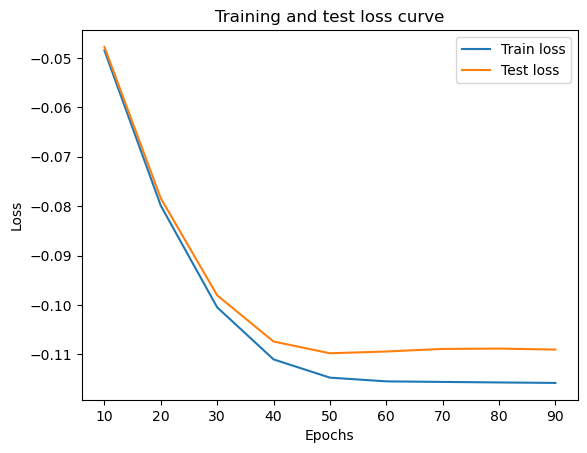

In [13]:
train_model(model_heston, optimizer_heston, loss_fn, X_train_heston, X_test_heston, epochs = 100)

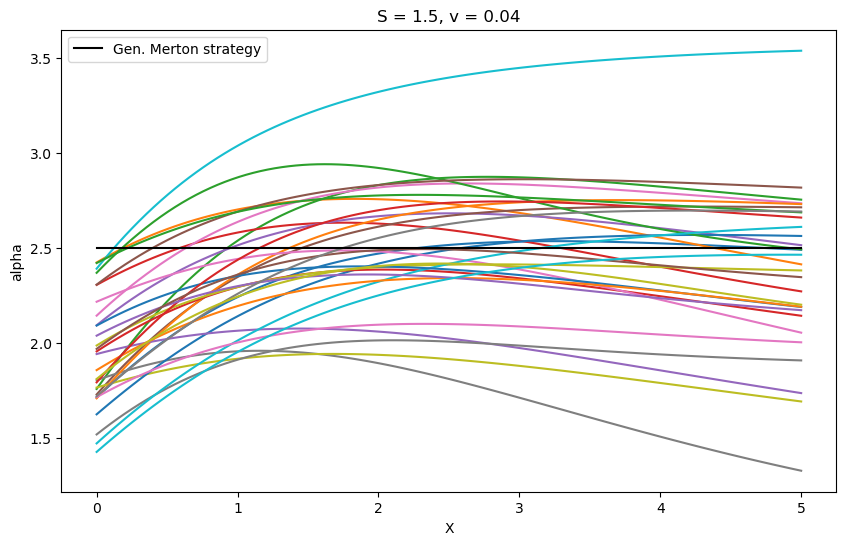

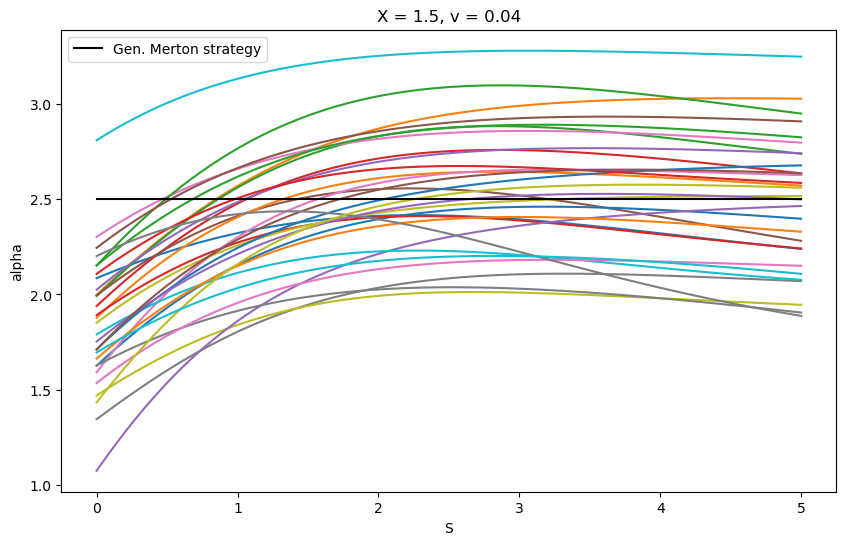

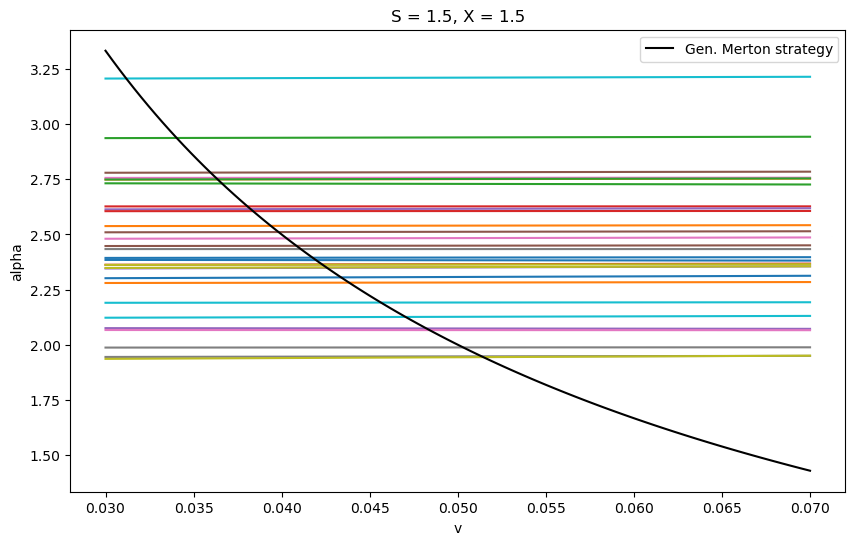

In [14]:
# plot learned strategy for each time t = 0,...,20, fixed S = 1.5, fixed volatility v = 0.04 and varying X
S = 1.5
v = 0.04
plt.figure(figsize = (10, 6))
a = 0
b = 5
n = 100
X = np.linspace(a, b, n)
for i in range(N):
    alpha = lambda x: model_heston.strategy(i, S, x, v).detach().numpy()
    plt.plot(X, list(map(alpha, X)))
plt.plot(X, np.ones(len(X)) * (model_params_heston['mu'] - model_params_heston['r']) / v, color = "black", label = "Gen. Merton strategy")
plt.xlabel("X")
plt.ylabel("alpha")
plt.legend()
plt.title("S = " + str(S) + ", v = " + str(v))
plt.show()

# plot learned strategy for each time t = 0,...,20, fixed X = 1.5, fixed volatility v = 0.04 and varying S
X = 1.5
v = 0.04
plt.figure(figsize = (10, 6))
a = 0
b = 5
n = 100
S = np.linspace(a, b, n)
for i in range(N):
    alpha = lambda s: model_heston.strategy(i, s, X, v).detach().numpy()
    plt.plot(S, list(map(alpha, S)))
plt.plot(S, np.ones(len(S)) * (model_params_heston['mu'] - model_params_heston['r']) / v, color = "black", label = "Gen. Merton strategy")
plt.xlabel("S")
plt.ylabel("alpha")
plt.legend()
plt.title("X = " + str(X) + ", v = " + str(v))
plt.show()

# plot learned strategy for each time t = 0,...,20, fixed S = 1.5, varying volatility v and fixed X = 1.5
S = 1.5
X = 1.5
plt.figure(figsize = (10, 6))
a = 0.03
b = 0.07
n = 100
v = np.linspace(a, b, n)
for i in range(N):
    alpha = lambda v: model_heston.strategy(i, S, X, v).detach().numpy()
    plt.plot(v, list(map(alpha, v)))
plt.plot(v, np.ones(len(v)) * (model_params_heston['mu'] - model_params_heston['r']) / v, color = "black", label = "Gen. Merton strategy")
plt.xlabel("v")
plt.ylabel("alpha")
plt.legend()
plt.title("S = " + str(S) + ", X = " + str(X))
plt.show()

In [15]:
# create evaluation data set.
np.random.seed(42)
evaluation_data = build_data_heston(N = N, K = 10 ** 4)

Data built. Shape of data : torch.Size([60, 10000])


In [16]:
# define strategies
def alpha1(*args):
    return 1

def alpha2(*args):
    # random value between 0 and 1
    return np.random.uniform(0, 1)

def alpha3(*args):
    # args corresond to time, stock, wealth, volatility
    return (model_params_heston['mu'] - model_params_heston['r']) / args[3]

In [17]:
# We build a function which takes a deterministic strategy $\alpha(t,s,x,v) as input
def evaluate_strategy(X_data, strategy, name, model_params, N = 30):
    # assert that length of training data matches (data for stock and volatility)
    assert(2 * N == X_data.shape[0])

    # parameters
    T = model_params['T']
    h = T / N
    v0 = model_params['v0']
    S0 = model_params['S0']
    X0 = model_params['X0']
    mu = model_params['mu']
    r = model_params['r']
    rho = model_params['rho']
    kappa = model_params['kappa']
    theta = model_params['theta']
    xi = model_params['xi']

    # initialize volatility, (log) price and (log) wealth
    v = v0 * torch.ones_like(X_data[0], dtype = torch.float32)
    S = S0 * torch.ones_like(X_data[0], dtype = torch.float32)
    X = X0 * torch.ones_like(X_data[0], dtype = torch.float32)
    logS = torch.log(S)
    logX = torch.log(X)

    # iterate
    for i in range(N):
        # wealth update
        alpha = strategy(i, S, X, v)
        logX = logX + (alpha * mu + (1 - alpha) * r - alpha ** 2 * v / 2) * h + alpha * torch.sqrt(v * h) * X_data[i,]
        X = torch.exp(logX)

        # stock update
        #S_for_integrated_variance = S
        logS = logS + (mu - v / 2) * h + torch.sqrt(v * h) * X_data[i,]
        S = torch.exp(logS)

        # volatility update
        Z = (rho * X_data[i] + np.sqrt(1 - rho ** 2) * X_data[N + i])
        v = v + kappa * (theta - v) * h + xi * torch.sqrt(v * h) * Z

    # return output
    return X

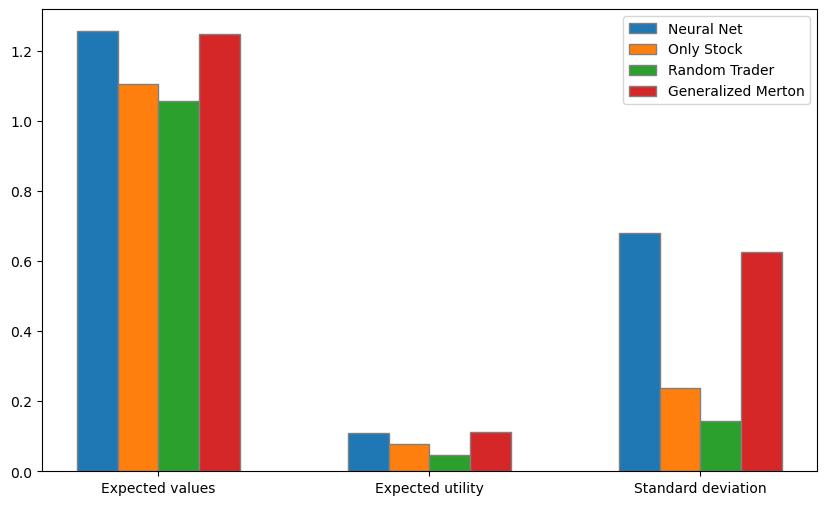

In [18]:
# get X_T based on different strategies
strategy_set = [alpha1, alpha2, alpha3]
strat_names = ['Only Stock', 'Random Trader', 'Generalized Merton']
end_values = []
for i in range(len(strategy_set)):
    vals = evaluate_strategy(evaluation_data, strategy_set[i], strat_names[i], model_params_heston, N = N)
    end_values.append(vals)

# add neural net
end_values = [model_heston(evaluation_data)] + end_values
strat_names = ['Neural Net'] + strat_names

# get expected values and log utility
strat_expected_values = [torch.mean(end_values[i]).detach().numpy() for i in range(len(strat_names))]
strat_expected_utility = [torch.mean(torch.log(end_values[i])).detach().numpy() for i in range(len(strat_names))]
strat_sd = [torch.std(end_values[i]).detach().numpy() for i in range(len(strat_names))]

# get tensor
data = np.vstack((strat_expected_values, strat_expected_utility, strat_sd))

# plot histograms
bar_width = 0.15
plt.figure(figsize = (10, 6))
for i in range(len(strat_names)):
    r = np.arange(3) + i * bar_width
    plt.bar(r, data[:,i], width=bar_width, edgecolor='grey', label=strat_names[i])
plt.xticks([r + 1.5 * bar_width for r in range(3)], ['Expected values', 'Expected utility', 'Standard deviation'])
plt.legend();

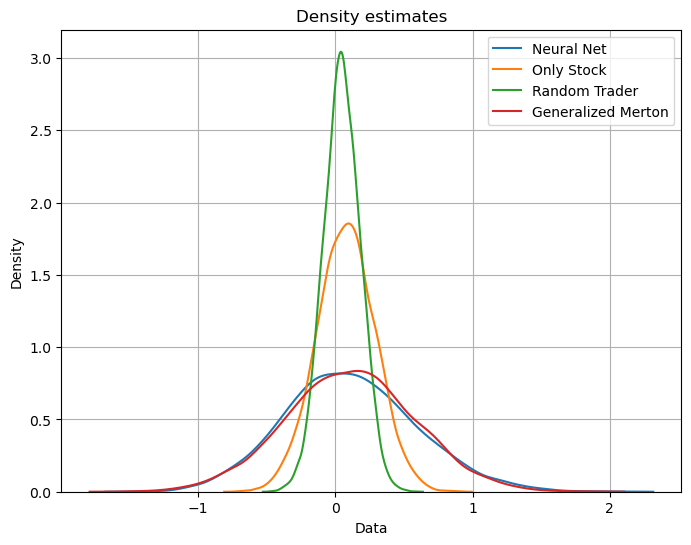

In [19]:
import seaborn as sns
plt.figure(figsize=(8, 6))
for i in range(len(end_values)):
    data = np.log(end_values[i].detach().numpy())
    sns.kdeplot(data, label = strat_names[i])
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Density estimates')
plt.legend()
plt.grid(True)
plt.show()

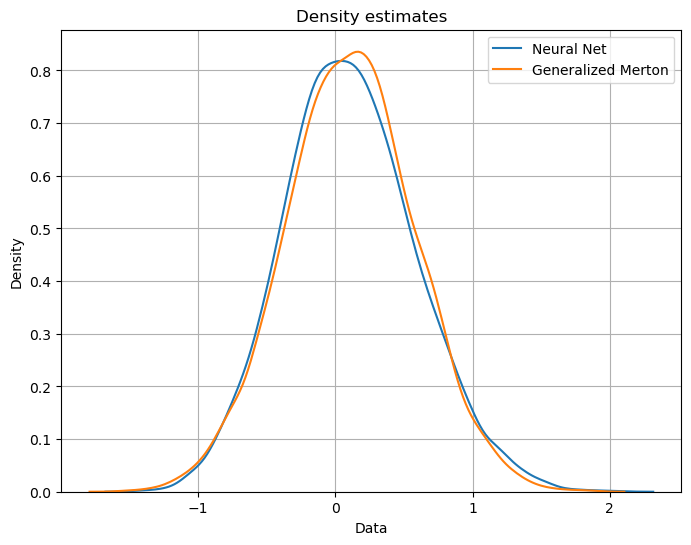

Expected utility of neural network strategy:     0.1079486683011055
Expected utility of generalized merton strategy: 0.11091277003288269


In [20]:
# compare learnt strategy and generalized merton strategy
plt.figure(figsize=(8, 6))
sns.kdeplot(np.log(end_values[0].detach().numpy()), label = strat_names[0])
sns.kdeplot(np.log(end_values[3].detach().numpy()), label = strat_names[3])
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Density estimates')
plt.legend()
plt.grid(True)
plt.show()

print(f"Expected utility of neural network strategy:     {strat_expected_utility[0]}")
print(f"Expected utility of generalized merton strategy: {strat_expected_utility[3]}")